In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220707_VARprocess_EC_50subjects_10.0s_segment_1200.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010034_EC     6
sub-010007_EC     8
sub-010053_EC     7
sub-010031_EC     6
sub-010004_EC     6
sub-010029_EC     6
sub-010060_EC     6
sub-010045_EC     6
sub-010049_EC     5
sub-010064_EC     5
sub-010065_EC     6
sub-010079_EC     6
sub-010076_EC     6
sub-010067_EC     6
sub-010080_EC     6
sub-010136_EC     5
sub-010088_EC     5
sub-010137_EC     6
sub-010138_EC     8
sub-010142_EC     4
sub-010165_EC     6
sub-010152_EC     8
sub-010197_EC     6
sub-010204_EC     6
sub-010213_EC     8
sub-010238_EC     6
sub-010239_EC     4
sub-010241_EC     6
sub-010247_EC     6
sub-010248_EC     6
sub-010276_EC     1
sub-010249_EC     6
sub-010265_EC     8
sub-010267_EC     6
sub-010271_EC     6
sub-010250_EC     5
sub-010270_EC     6
sub-010268_EC    10
sub-010274_EC     6
sub-010275_EC     5
sub-010289_EC     6
sub-010290_EC     6
sub-010296_EC    10
sub-010297_EC     6
sub-010316_EC     6
sub-010310_EC     6
sub-010301_EC     6
sub-010304_EC     6
sub-010311_EC     5
sub-010319_EC     6


6.0

6.06

<AxesSubplot:xlabel='order', ylabel='AIC'>

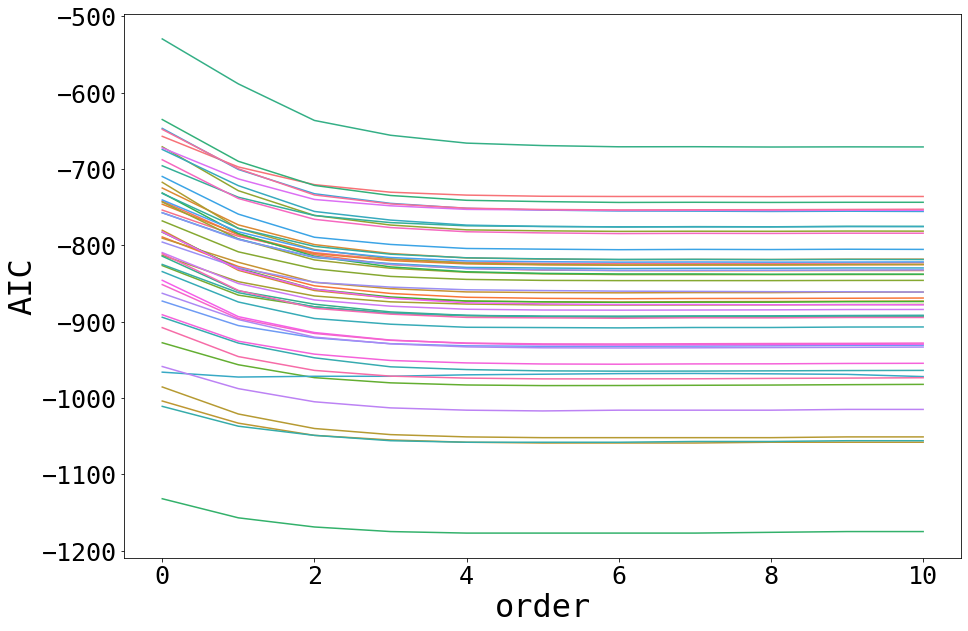

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_7046/171016283.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_7046/171016283.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


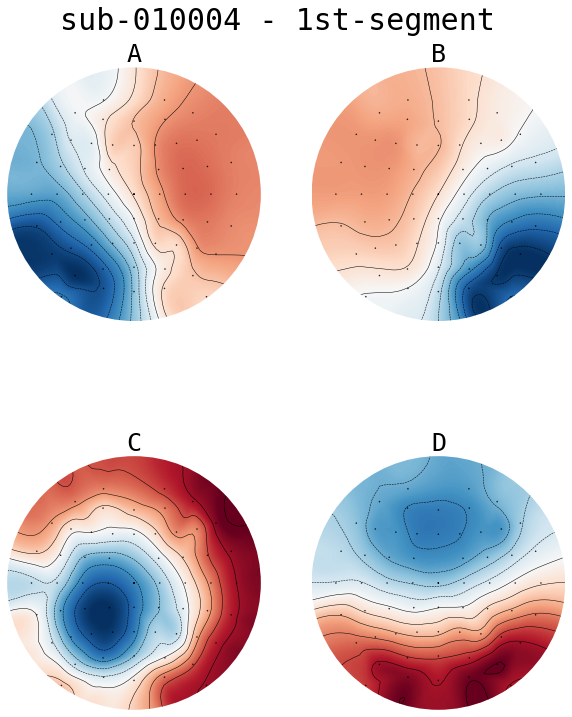

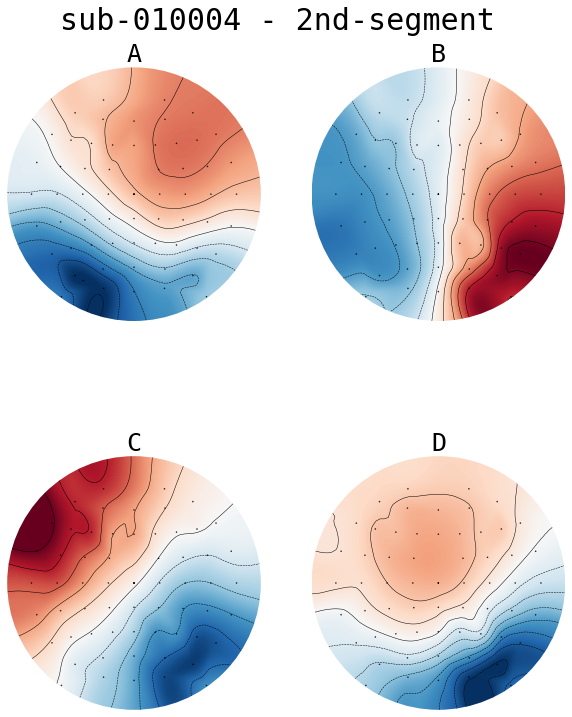

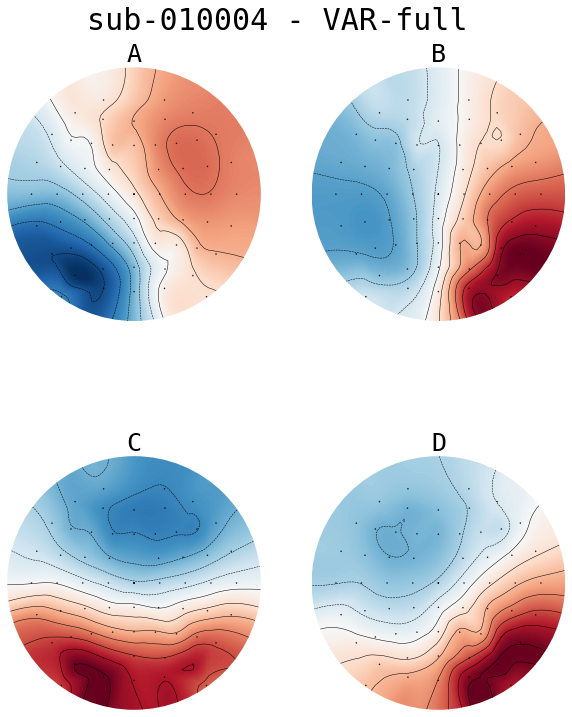

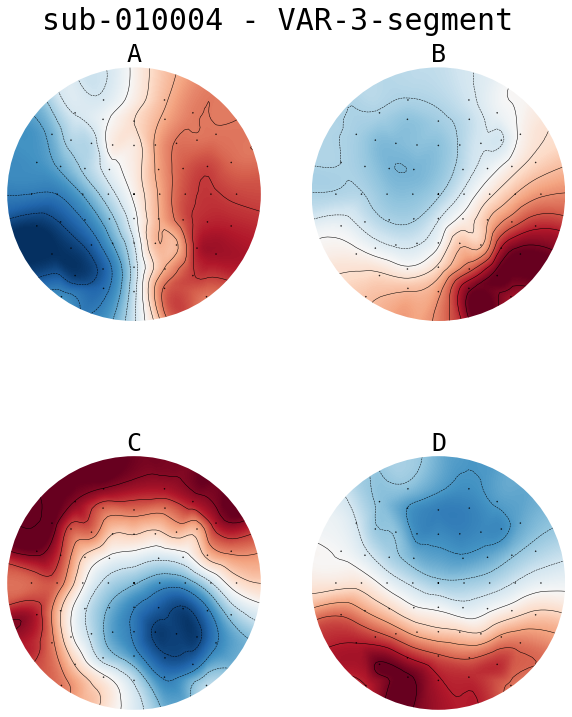

In [5]:
subj_id = "sub-010004"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

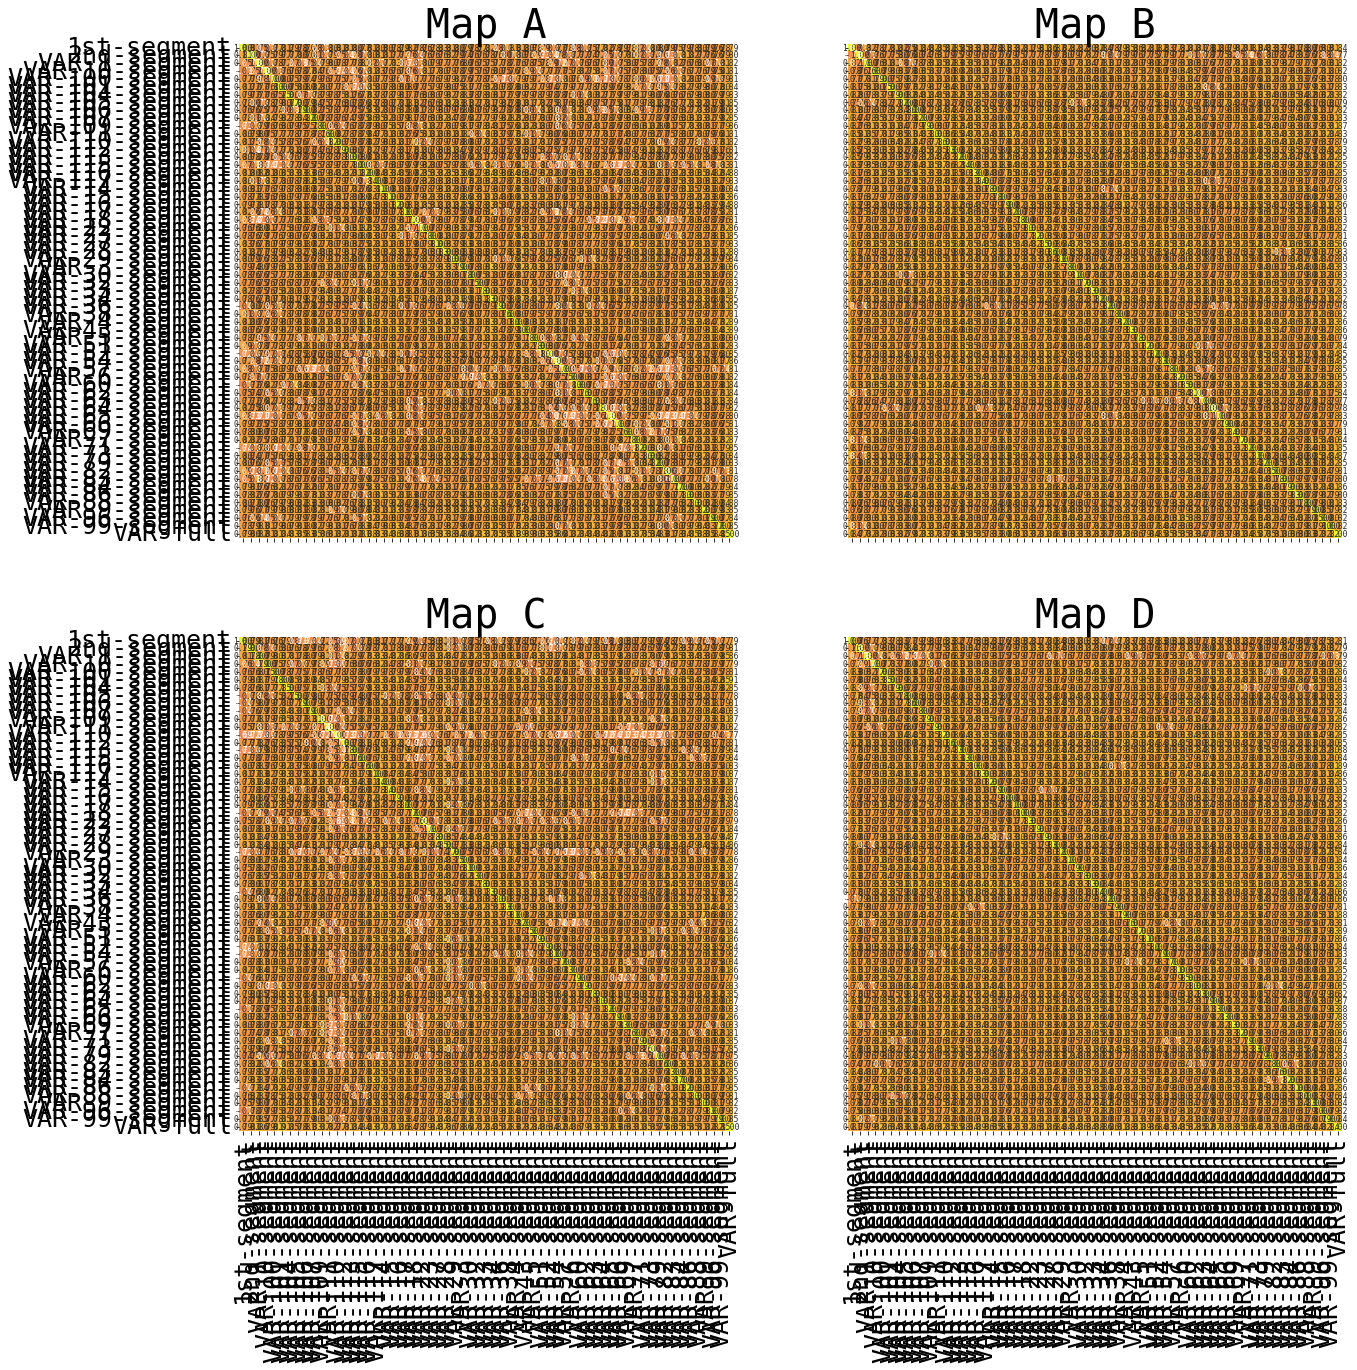

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [02:25<00:00, 154.20it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

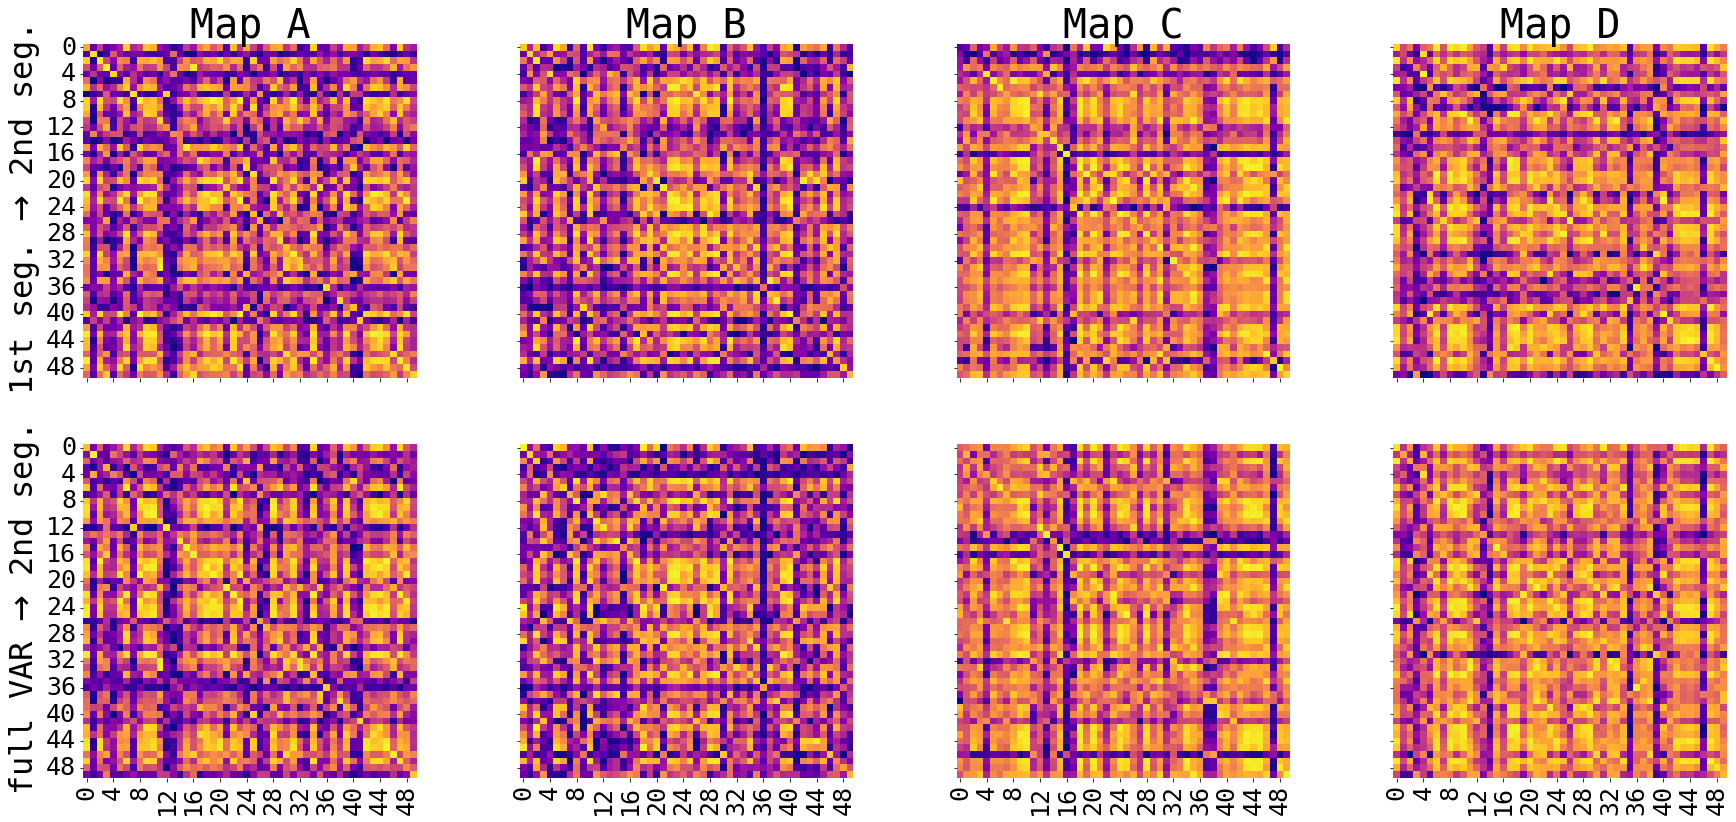

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

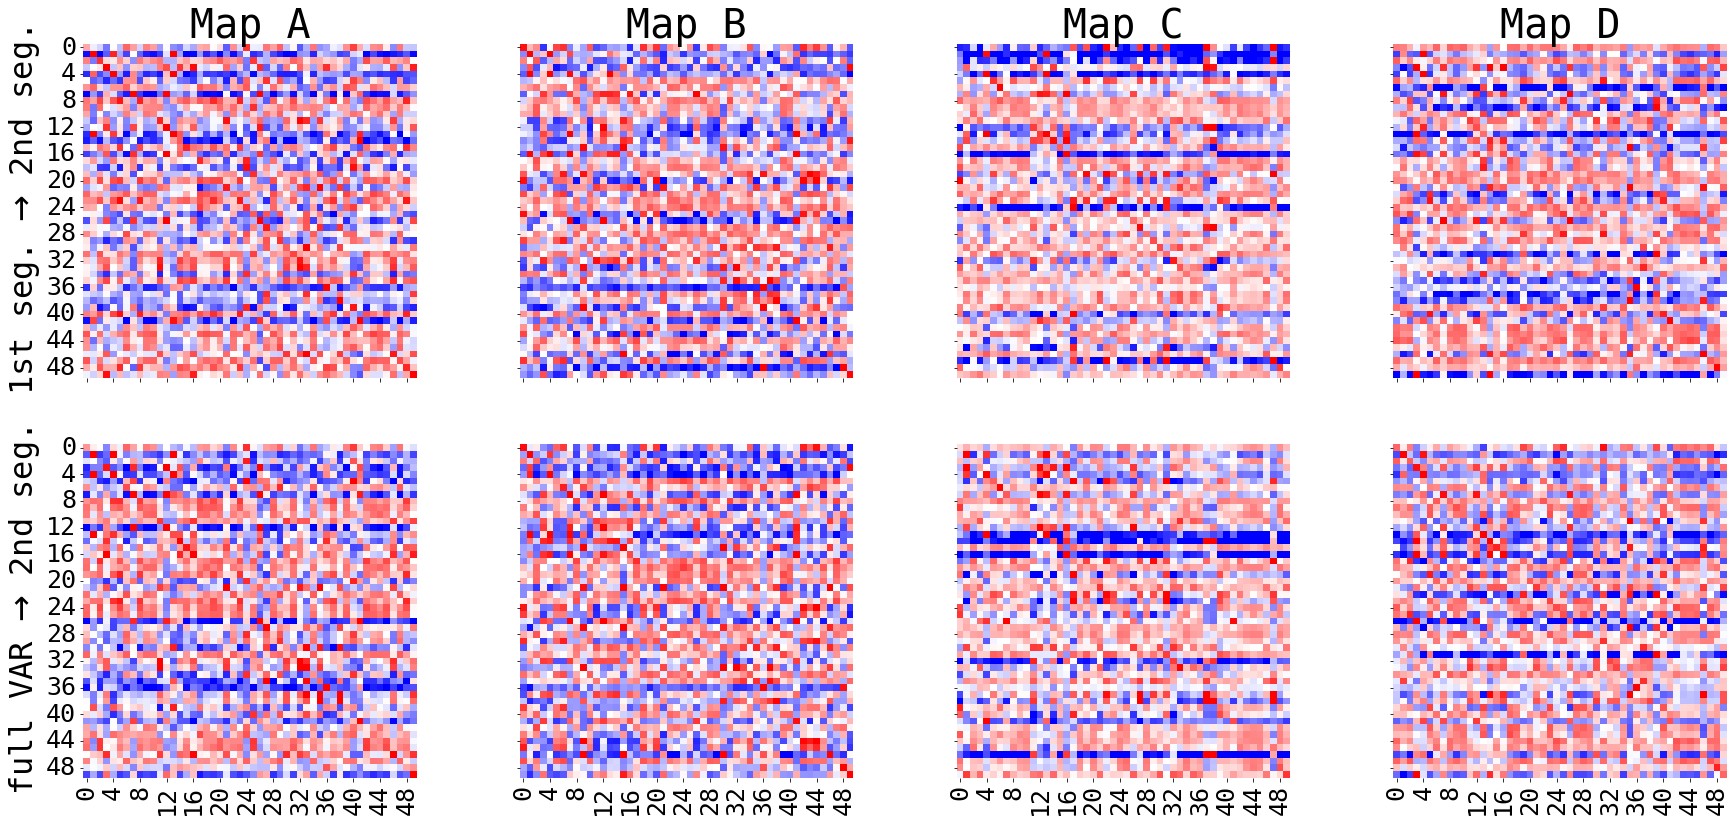

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

A   B   C   D
1st-segment  21  16  17  14
VAR-full     20  16  16  18

A   B   C   D
1st-segment  21  16  17  14
VAR-full     20  16  16  18

# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010004 1st-segment       A           0.748538   0.695470       0.871542   
                             B           0.748538   0.695470       0.917255   
                             C           0.748538   0.695470       0.702028   
                             D           0.748538   0.695470       0.911165   
           2nd-segment       A           0.767935   0.705342       0.982171   
...                                           ...        ...            ...   
sub-010316 VAR-segments-mean D           0.847954   0.780290       0.906589   
sub-010319 VAR-segments-mean A           0.765181   0.705254       0.742691   
                             B           0.765181   0.705254       0.815008   
                             C           0.765181   0.705254       0.864888   
                             D           0.765181   0.705254       0.820236   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010004 1st-segment       A           0.262695   15.793683  16.713376   
                             B           0.277089   16.693323  16.598802   
                             C           0.177929   11.795282  15.084746   
                             D           0.282287   16.993203  16.588235   
           2nd-segment       A           0.274690   17.493003  15.702857   
...                                           ...         ...        ...   
sub-010316 VAR-segments-mean D           0.254305   14.076036  18.208593   
sub-010319 VAR-segments-mean A           0.236839   13.754498  17.225059   
                             B           0.262728   13.691190  19.189592   
                             C           0.250280   13.632880  18.361045   
                             D           0.250153   13.033120  19.129998   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010004 1st-segment       A                0.759513       0.101979   
                             B                0.086580       0.759019   
                             C                0.094382       0.067416   
                             D                0.078014       0.099291   
           2nd-segment       A                0.745269       0.125182   
...                                                ...            ...   
sub-010316 VAR-segments-mean D                0.064854       0.100745   
sub-010319 VAR-segments-mean A                0.766444       0.080691   
                             B                0.067542       0.788917   
                             C                0.080608       0.070886   
                             D                0.069783       0.073545   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010004 1st-segment       A                0.051750       0.086758  
                             B                0.056277       0.098124  
                             C                0.734831       0.103371  
                             D                0.063830       0.758865  
           2nd-segment       A                0.042213       0.087336  
...                                                ...            ...  
sub-010316 VAR-segments-mean D                0.057108       0.777294  
sub-010319 VAR-segments-mean A                0.077835       0.075030  
                             B                0.074775       0.068766  
                             C                0.780770       0.067736  
                             D                0.067168       0.789504  

[800 rows x 10 columns]

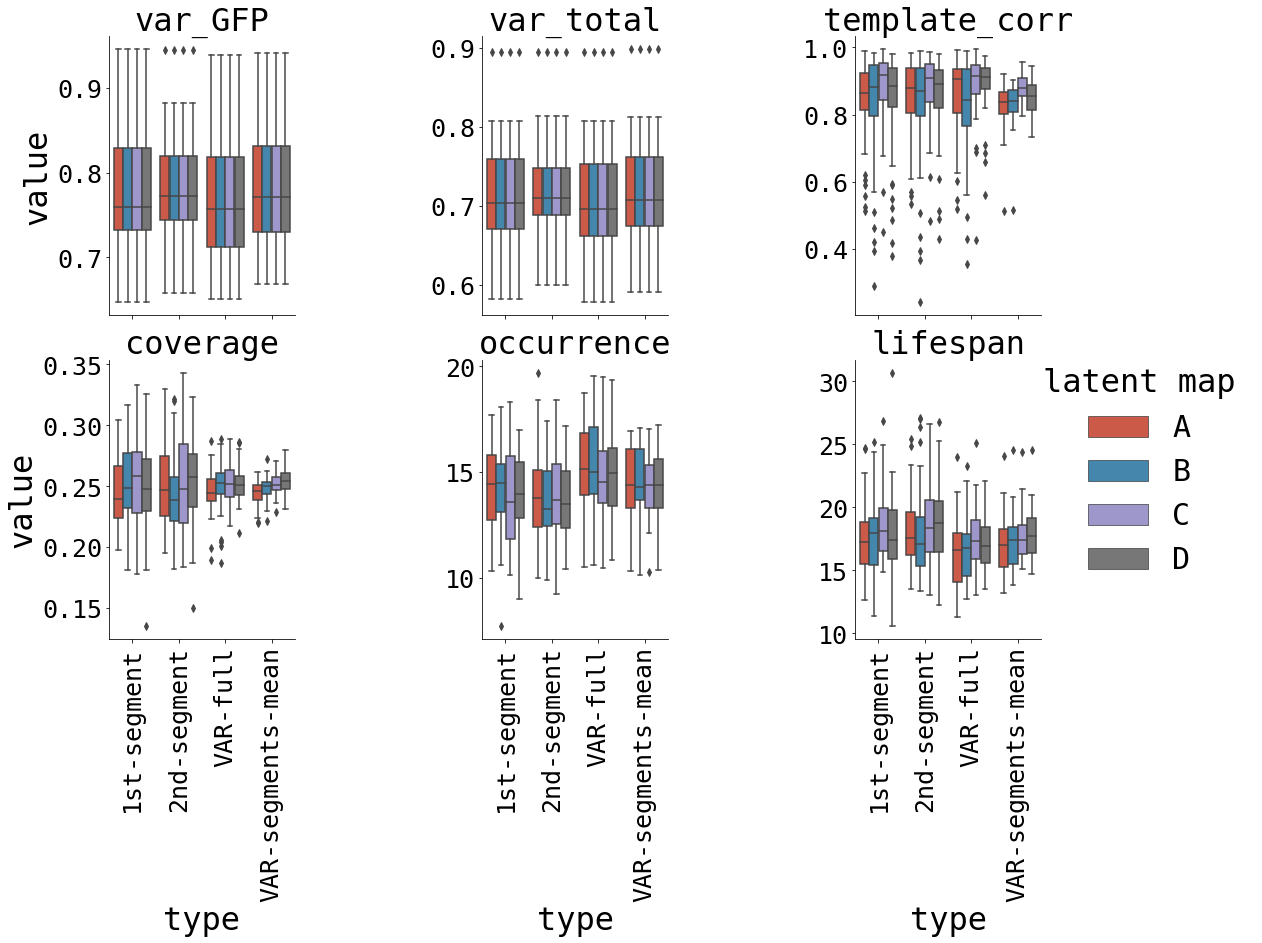

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2     98  79.837452  2.676355e-21  0.033616  0.753676

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric          T   dof  \
0    diffs      VAR-full  VAR-segments    True        True  18.588230  49.0   
1    diffs      VAR-full     real_data    True        True   7.334540  49.0   
2    diffs  VAR-segments     real_data    True        True  -3.411058  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  7.731701e-24  4.252436e-23   fdr_by  4.892e+20  0.446227  
1   two-sided  2.014800e-09  5.540700e-09   fdr_by  5.759e+06  0.297567  
2   two-sided  1.304808e-03  2.392148e-03   fdr_by     22.451 -0.132909

== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2     98  83.395733  7.043402e-22  0.019386  0.684836

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric          T   dof  \
0    diffs      VAR-full  VAR-segments    True        True  20.224872  49.0   
1    diffs      VAR-full     real_data    True        True   8.429761  49.0   
2    diffs  VAR-segments     real_data    True        True  -1.516629  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  1.975716e-25  1.086644e-24   fdr_by  1.744e+22  0.308452  
1   two-sided  4.239223e-11  1.165786e-10   fdr_by  2.293e+08  0.268159  
2   two-sided  1.357858e-01  2.489406e-01   fdr_by      0.449 -0.043614

== template_corr ==


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2     98  6.945255  0.001511  0.034355  0.803544

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -3.787417  49.0   
1    diffs      VAR-full     real_data    True        True -2.678633  49.0   
2    diffs  VAR-segments     real_data    True        True -0.099011  49.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.000417  0.002291   fdr_by  62.636 -0.400491  
1   two-sided  0.010034  0.027594   fdr_by   3.746 -0.374686  
2   two-sided  0.921533  1.000000   fdr_by   0.155 -0.011182

== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2        F     p-unc       ng2       eps
0  diffs      2     98  1.00473  0.369883  0.006458  0.757978

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -1.179310  49.0   
1    diffs      VAR-full     real_data    True        True -1.093059  49.0   
2    diffs  VAR-segments     real_data    True        True -0.428557  49.0   

  alternative     p-unc   p-corr p-adjust   BF10    hedges  
0   two-sided  0.243969  0.76921   fdr_by  0.296 -0.145777  
1   two-sided  0.279713  0.76921   fdr_by   0.27 -0.171206  
2   two-sided  0.670124  1.00000   fdr_by  0.168 -0.051618

== occurrence ==


Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  diffs      2     98  51.367671  5.514541e-16  8.346718e-13  0.102345   

        eps  sphericity   W-spher   p-spher  
0  0.766423       False  0.695238  0.000163

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -6.909774  49.0   
1    diffs      VAR-full     real_data    True        True -8.085343  49.0   
2    diffs  VAR-segments     real_data    True        True -4.540510  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  9.152318e-09  2.516887e-08   fdr_by  1.368e+06 -0.499669  
1   two-sided  1.415196e-10  7.783576e-10   fdr_by  7.242e+07 -0.776138  
2   two-sided  3.663641e-05  6.716675e-05   fdr_by    576.593 -0.303387

== lifespan ==


Source  ddof1  ddof2        F         p-unc     p-GG-corr       ng2  \
0  diffs      2     98  57.1864  3.485235e-17  1.124194e-13  0.078303   

        eps  sphericity   W-spher   p-spher  
0  0.762818       False  0.689072  0.000131

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True  8.307927  49.0   
1    diffs      VAR-full     real_data    True        True  8.661591  49.0   
2    diffs  VAR-segments     real_data    True        True  4.625897  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  6.486357e-11  1.783748e-10   fdr_by  1.526e+08  0.398058  
1   two-sided  1.893933e-11  1.041663e-10   fdr_by  4.959e+08  0.689552  
2   two-sided  2.753628e-05  5.048319e-05   fdr_by    750.197  0.302809

In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010004 1st-segment           3.118069  1.977932          2.0   
           2nd-segment           3.116633  1.987828          2.0   
           VAR-full              3.053281  1.998135          2.0   
sub-010007 1st-segment           3.209959  1.969428          2.0   
           2nd-segment           3.062413  1.994248          2.0   
...                                   ...       ...          ...   
sub-010304 VAR-segments-mean     3.708154  1.978745          2.0   
sub-010310 VAR-segments-mean     3.663917  1.992931          2.0   
sub-010311 VAR-segments-mean     3.789136  1.987165          2.0   
sub-010316 VAR-segments-mean     3.589919  1.982421          2.0   
sub-010319 VAR-segments-mean     3.746806  1.987578          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010004 1st-segment            1.098441         1.183457     44.000000  
           2nd-segment            1.125703         1.220680     44.000000  
           VAR-full               1.199364         1.285008     44.000000  
sub-010007 1st-segment            1.091123         1.166911     64.000000  
           2nd-segment            1.145154         1.236000     72.000000  
...                                    ...              ...           ...  
sub-010304 VAR-segments-mean      1.002075         1.075402     51.866667  
sub-010310 VAR-segments-mean      1.024383         1.094788     52.000000  
sub-010311 VAR-segments-mean      1.014348         1.088488     55.066667  
sub-010316 VAR-segments-mean      1.009424         1.089629     49.133333  
sub-010319 VAR-segments-mean      1.016281         1.089080     49.933333  

[200 rows x 6 columns]

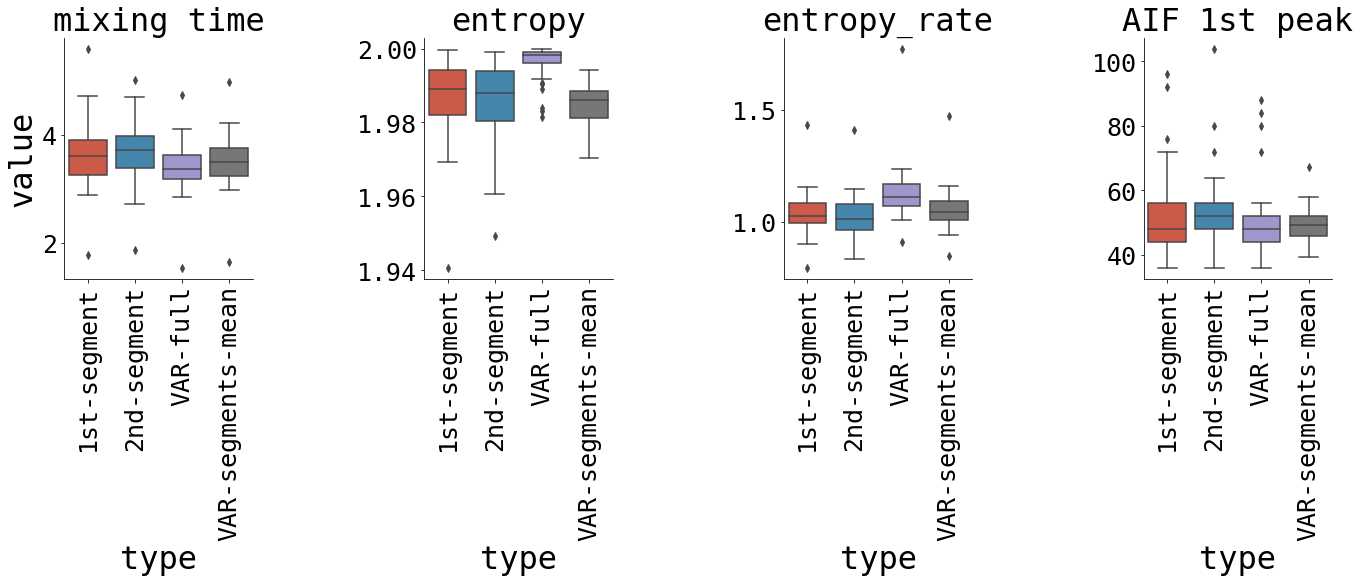

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

subject_id  mixing time   entropy  max entropy  entropy_rate  \
0   sub-010004     3.118069  1.977932          2.0      1.098441   
0   sub-010004     3.116633  1.987828          2.0      1.125703   
0   sub-010004     3.079550  1.995370          2.0      1.167949   
0   sub-010004     3.464599  1.993780          2.0      1.098664   
0   sub-010004     3.201567  1.992478          2.0      1.111122   
..         ...          ...       ...          ...           ...   
0   sub-010319     3.499325  1.987022          2.0      1.030083   
0   sub-010319     3.688563  1.997276          2.0      1.010785   
0   sub-010319     3.862907  1.990102          2.0      1.008496   
0   sub-010319     3.997808  1.980520          2.0      0.982075   
0   sub-010319     3.629230  1.999224          2.0      1.084481   

    MC entropy rate  AIF 1st peak             type  
0          1.183457          44.0      1st-segment  
0          1.220680          44.0      2nd-segment  
0          1.269785          44.0    VAR-1-segment  
0          1.179962          44.0   VAR-10-segment  
0          1.201969          44.0  VAR-100-segment  
..              ...           ...              ...  
0          1.111645          48.0   VAR-88-segment  
0          1.078147          52.0    VAR-9-segment  
0          1.081721          52.0   VAR-96-segment  
0          1.040503          52.0   VAR-99-segment  
0          1.116612          48.0         VAR-full  

[3150 rows x 8 columns]

In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

subject_id  mixing time   entropy  entropy_rate  AIF 1st peak  \
0    sub-010004    -0.001436  0.009896      0.027263      0.000000   
1    sub-010007    -0.147546  0.024820      0.054031      8.000000   
2    sub-010029    -0.086224 -0.006749     -0.020754      4.000000   
3    sub-010031    -0.011178 -0.014225      0.036776      0.000000   
4    sub-010034     0.103307 -0.002524     -0.008135     -4.000000   
..          ...          ...       ...           ...           ...   
145  sub-010304     0.211312 -0.002125     -0.017964      0.133333   
146  sub-010310     0.055247 -0.013587     -0.041371     52.000000   
147  sub-010311    -0.069558  0.006816     -0.034106      0.933333   
148  sub-010316     0.787152 -0.021760     -0.091794     -1.133333   
149  sub-010319    -0.027953  0.008077     -0.003963      2.066667   

            diffs  
0       real_data  
1       real_data  
2       real_data  
3       real_data  
4       real_data  
..            ...  
145  VAR-segments  
146  VAR-segments  
147  VAR-segments  
148  VAR-segments  
149  VAR-segments  

[150 rows x 6 columns]

In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


Source  ddof1  ddof2          F         p-unc     p-GG-corr      ng2  \
0  diffs      2     98  32.383408  1.597167e-11  4.232731e-08  0.06947   

        eps  sphericity   W-spher       p-spher  
0  0.630643       False  0.414316  6.545819e-10

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True  7.174683  49.0   
1    diffs      VAR-full     real_data    True        True  6.523879  49.0   
2    diffs  VAR-segments     real_data    True        True  3.990595  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  3.559191e-09  1.957555e-08   fdr_by  3.353e+06  0.294864  
1   two-sided  3.627014e-08  9.974287e-08   fdr_by  3.714e+05  0.652252  
2   two-sided  2.199587e-04  4.032576e-04   fdr_by    111.747  0.363698

== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2     98  43.982579  2.333082e-14  0.148118  0.673136

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric          T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -14.996913  49.0   
1    diffs      VAR-full     real_data    True        True  -5.806825  49.0   
2    diffs  VAR-segments     real_data    True        True   1.528681  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  6.082768e-20  3.345523e-19   fdr_by  7.931e+16 -1.085038  
1   two-sided  4.637795e-07  1.275394e-06   fdr_by  3.365e+04 -0.731005  
2   two-sided  1.327740e-01  2.434191e-01   fdr_by      0.456  0.162335

== entropy_rate ==


Source  ddof1  ddof2           F         p-unc       ng2     eps
0  diffs      2     98  174.912557  4.631950e-33  0.365091  0.6789

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric          T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -15.414540  49.0   
1    diffs      VAR-full     real_data    True        True -13.528535  49.0   
2    diffs  VAR-segments     real_data    True        True  -3.579302  49.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  1.994522e-20  1.096987e-19   fdr_by  2.343e+17 -1.415491  
1   two-sided  3.616272e-18  9.944749e-18   fdr_by  1.505e+15 -1.601996  
2   two-sided  7.886213e-04  1.445806e-03   fdr_by     35.237 -0.252532

== AIF 1st peak ==


Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2     98  1.297401  0.277892   0.271175  0.006342  0.690399   

   sphericity   W-spher       p-spher  
0       False  0.551562  6.284515e-07

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast             A             B  Paired  Parametric         T   dof  \
0    diffs      VAR-full  VAR-segments    True        True -0.169319  49.0   
1    diffs      VAR-full     real_data    True        True  1.045358  49.0   
2    diffs  VAR-segments     real_data    True        True  1.532675  49.0   

  alternative     p-unc    p-corr p-adjust   BF10    hedges  
0   two-sided  0.866243  1.000000   fdr_by  0.156 -0.014739  
1   two-sided  0.300987  0.827714   fdr_by  0.257  0.146510  
2   two-sided  0.131788  0.724832   fdr_by  0.459  0.180401